# Coordinate Shifts Parameter Estimation

This notebook demonstrates a challenging test case for parameter estimation using the `LorenzParameterEstimation` package: learning coordinate shifts in the Lorenz 63 system.

## Problem Description

We modify the standard Lorenz 63 system by introducing coordinate shifts:
- x → x - x_s
- y → y - y_s  
- z → z - z_s

The goal is to learn the shift parameters (x_s, y_s, z_s) using the package's Enzyme.jl integration when starting from unstable initial conditions `randn(3) .+ (0, 0, 10)`. This transforms the problem from an initial condition problem to a climate problem.

**Key insight**: The shifts provide smooth gradients (constants in parameter space), making this an ideal test case for gradient-based optimization and showcasing the package's capabilities.

## Setup and Imports

In [1]:
# Activate the local LorenzParameterEstimation package
import Pkg
Pkg.activate("../../")  # Activate the main project environment
Pkg.instantiate()  # Ensure all dependencies are installed

using DifferentialEquations
using Plots
using Random
using LinearAlgebra
using Statistics
using Enzyme

using LorenzParameterEstimation

# Set random seed for reproducibility
Random.seed!(42)

  Activating project at `~/master_thesis/LorenzParameterEstimation`
project at `~/master_thesis/LorenzParameterEstimation`
Precompiling Precompiling project...
project...
   1848.6 ms  ✓ LorenzParameterEstimation
   1848.6 ms  ✓ LorenzParameterEstimation
   6118.9 ms  ✓ LorenzParameterEstimation → LorenzVisualizationExt
  2 dependencies successfully precompiled in 10 seconds. 601 already precompiled.
   6118.9 ms  ✓ LorenzParameterEstimation → LorenzVisualizationExt
  2 dependencies successfully precompiled in 10 seconds. 601 already precompiled.


TaskLocalRNG()

## Base System Setup

First, let's use the package's standard parameters and utilities.

In [2]:
base_params = classic_params()
println("Base params: $base_params")

# Add coordinate shifts: x_s=10, y_s=0, z_s=0
shifted_params = with_coordinate_shifts(base_params, 10.0, 0.0, 0.0)
println("Shifted params: $shifted_params")

# Test parameter utilities
parameter_summary(base_params)
println()
parameter_summary(shifted_params)

Base params: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.0)
Shifted params: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 10.0, 0.0, 0.0, 1.0)
L63Parameters Summary:
  Core parameters: σ=10.0, ρ=28.0, β=2.6666666666666665
  Coordinate shifts: None (all zero)
  Theta modification: None (θ=1)

L63Parameters Summary:
  Core parameters: σ=10.0, ρ=28.0, β=2.6666666666666665
  Coordinate shifts: x_s=10.0, y_s=0.0, z_s=0.0
  Theta modification: None (θ=1)


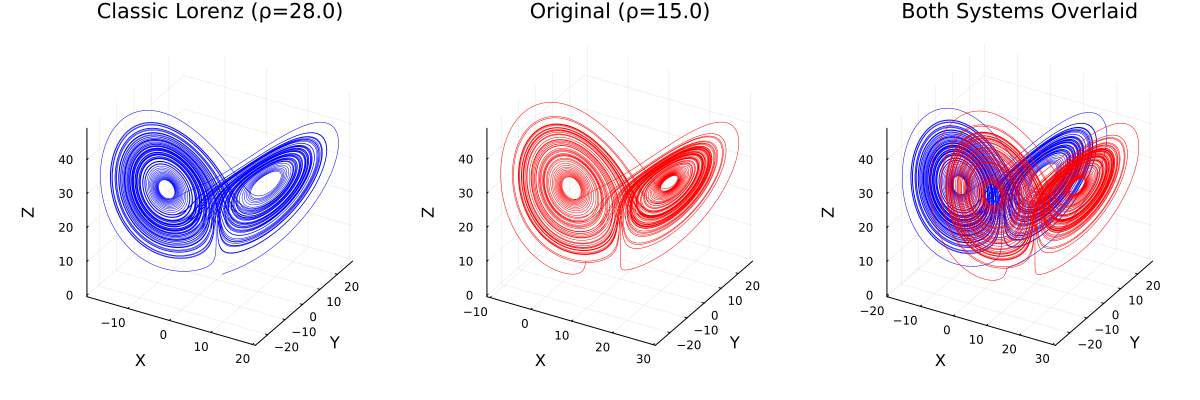

In [3]:
# Initial condition 
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M
# Integrate both systems
sol_basic  = integrate(base_params, u0, (0.0, T), dt)
sol_shifted  = integrate(shifted_params, u0, (0.0, T), dt)

# Integrate classic Lorenz system for comparison
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)

p1 = plot(sol_basic.u[:, 1], sol_basic.u[:, 2], sol_basic.u[:, 3];
            title="Classic Lorenz (ρ=28.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:blue, kwargs3d...)
p2 = plot(sol_shifted.u[:, 1], sol_shifted.u[:, 2], sol_shifted.u[:, 3];
            title="Original (ρ=15.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:red, kwargs3d...)
            # Plot both trajectories overlaid
            p3 = plot(sol_basic.u[:, 1], sol_basic.u[:, 2], sol_basic.u[:, 3];
                        title="Both Systems Overlaid", xlabel="X", ylabel="Y", zlabel="Z",
                        linecolor=:blue, label="Classic Lorenz (ρ=28.0)", kwargs3d...)
            plot!(p3, sol_shifted.u[:, 1], sol_shifted.u[:, 2], sol_shifted.u[:, 3];
                        linecolor=:red, label="Shifted Lorenz (ρ=15.0)", kwargs3d...)

            plot(p1, p2, p3, layout=(1,3), size=(1200, 400))


## Solve for the x shift

   Optimizer: AdamW
   Data: 186 train windows, 79 val windows
   Window size: 150, stride: 75
   Updating: x_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   9.227330 │   8.344068 │ x_s=0.117,y_s=0.000,z_s=0.000
    2 │   9.153548 │   8.277875 │ x_s=0.235,y_s=0.000,z_s=0.000
    3 │   9.077621 │   8.212058 │ x_s=0.352,y_s=0.000,z_s=0.000
    4 │   9.002758 │   8.143267 │ x_s=0.470,y_s=0.000,z_s=0.000
    5 │   8.929131 │   8.070344 │ x_s=0.590,y_s=0.000,z_s=0.000
    6 │   8.854539 │   7.996810 │ x_s=0.710,y_s=0.000,z_s=0.000
    7 │   8.780720 │   7.922611 │ x_s=0.829,y_s=0.000,z_s=0.000
    8 │   8.707180 │   7.848993 │ x_s=0.947,y_s=0.000,z_s=0.000
    9 │   8.633414 │   7.776106 │ x_s=1.063,y_s=0.000,z_s=0.000
   10 │   8.558860 │   7.705085 │ x_s=1.177,y_s=0.000,z_s=0.000
   11 │   8.491471 │   7.628925 │ x_s=1.298,y_s=0.000,z_s=0.000
   12 │   8.414772 │   7.555177 │ x_s=1.416,y_s=0.000,z_s=0.000
   13 │   8.

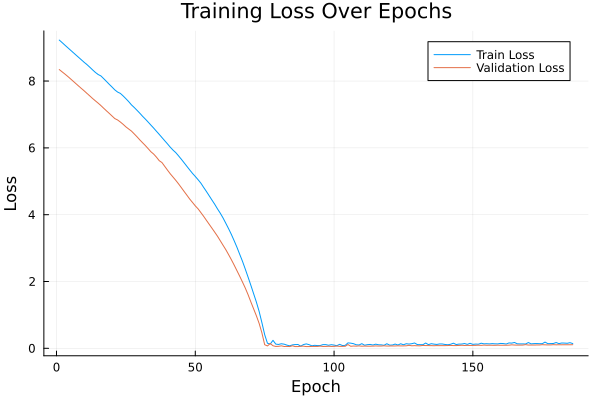

In [15]:
# Create initial guess parameters (starting from base params)
initial_params = with_coordinate_shifts(base_params, 0.0, 0.0, 0.0)  # Start with no shifts

# Try a more aggressive optimization approach for coordinate shifts
using LorenzParameterEstimation: adamw_config

results = modular_train!(
    initial_params,                                     # Initial parameter guess
    sol_shifted;                                        # Target trajectory to fit,                  
    optimizer_config = adamw_config(learning_rate=1e-2, weight_decay=1e-4), # Higher learning rate + regularization
    loss_function = window_rmse,                        # Loss function                                         
    epochs = 1000,                                      # More epochs
    window_size = 150,                                  # Smaller windows for more frequent updates
    stride = 75,                                        # Smaller stride (50% overlap)
    batch_size = 16,                                    # Smaller batches for more frequent updates
    train_fraction = 0.7,                               # Use more data for validation (30% instead of 20%)
    update_σ = false,                                   # Don't update σ parameter
    update_ρ = false,                                   # Don't update ρ parameter
    update_β = false,                                   # Don't update β parameter
    update_x_s = true,                                  # Update x_s coordinate shift
    update_y_s = false,                                 # Don't update y_s coordinate shift
    update_z_s = false,                                 # Don't update z_s coordinate shift
    verbose = true,                                     # Print training progress
    eval_every = 1,                                     # Evaluate EVERY epoch for better monitoring
    early_stopping_patience = 100,                      # More patience
    early_stopping_min_delta = 1e-8,                    # Smaller delta for more sensitive early stopping
)

# Extract results - now you can use direct field access!
best_params = results.best_params
println("Best parameters found: $best_params")
println("True x_s should be: 10.0")
println("Estimated x_s: $(best_params.x_s)")
println("Error: $(abs(best_params.x_s - 10.0))")


plot(results.train_loss, label="Train Loss", xlabel="Epoch", ylabel="Loss", title="Training Loss Over Epochs")
plot!(results.val_loss, label="Validation Loss")


=== Trying with better initial guess ===
   Optimizer: AdamW
   Data: 139 train windows, 60 val windows
   Window size: 200, stride: 100
   Updating: x_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   3.220353 │   3.190227 │ x_s=8.025,y_s=0.000,z_s=0.000
    2 │   3.189876 │   3.173188 │ x_s=8.050,y_s=0.000,z_s=0.000
    3 │   3.159778 │   3.136010 │ x_s=8.075,y_s=0.000,z_s=0.000
    4 │   3.129504 │   3.099222 │ x_s=8.099,y_s=0.000,z_s=0.000
    5 │   3.098036 │   3.062900 │ x_s=8.124,y_s=0.000,z_s=0.000
    6 │   3.068747 │   3.025430 │ x_s=8.149,y_s=0.000,z_s=0.000
    7 │   3.038213 │   2.987865 │ x_s=8.174,y_s=0.000,z_s=0.000
    8 │   3.003612 │   2.949811 │ x_s=8.199,y_s=0.000,z_s=0.000
    9 │   2.967879 │   2.915551 │ x_s=8.221,y_s=0.000,z_s=0.000
   10 │   2.947499 │   2.895584 │ x_s=8.234,y_s=0.000,z_s=0.000
   11 │   2.932011 │   2.873387 │ x_s=8.249,y_s=0.000,z_s=0.000
   12 │   2.917228 │   2.848562 │ 

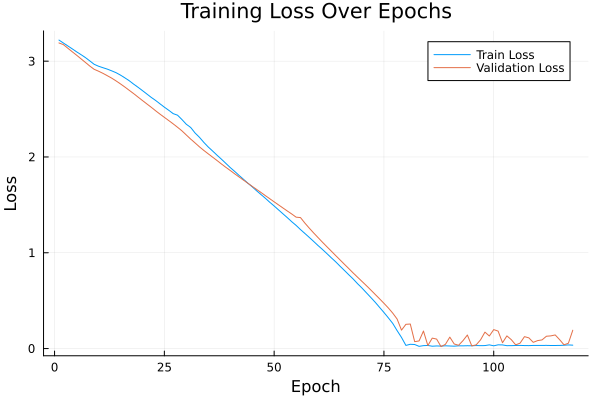

In [16]:
println("=== Trying with better initial guess ===")

# Start closer to the true value
better_initial = with_coordinate_shifts(base_params, 8.0, 0.0, 0.0)  # Start at x_s=8 (closer to true 10.0)

results2 = modular_train!(
    better_initial,                                     # Better initial parameter guess
    sol_shifted;                                        # Target trajectory to fit,                  
    optimizer_config = adamw_config(learning_rate=5e-3, weight_decay=1e-4), # More conservative learning rate
    loss_function = window_rmse,                        # Loss function                                         
    epochs = 500,                                       # Fewer epochs needed with good start
    window_size = 200,                                  # Medium window size
    stride = 100,                                       # 50% overlap
    batch_size = 32,                                    # Standard batch size
    train_fraction = 0.7,                               # More validation data
    update_σ = false,                                   # Don't update σ parameter
    update_ρ = false,                                   # Don't update ρ parameter
    update_β = false,                                   # Don't update β parameter
    update_x_s = true,                                  # Update x_s coordinate shift
    update_y_s = false,                                 # Don't update y_s coordinate shift
    update_z_s = false,                                 # Don't update z_s coordinate shift
    verbose = true,                                     # Print training progress
    eval_every = 1,                                     # Evaluate every epoch
    early_stopping_patience = 30,                       # Less patience with good initial guess
    early_stopping_min_delta = 1e-7,                    # More sensitive early stopping
)

best_params2 = results2.best_params
println("Results with better initial guess:")
println("Estimated x_s: $(best_params2.x_s)")
println("Error: $(abs(best_params2.x_s - 10.0))")


plot(results2.train_loss, label="Train Loss", xlabel="Epoch", ylabel="Loss", title="Training Loss Over Epochs")
plot!(results2.val_loss, label="Validation Loss")


=== Trying with MAE loss (might be more robust) ===
   Optimizer: AdamW
   Data: 159 train windows, 40 val windows
   Window size: 200, stride: 100
   Updating: x_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   7.718562 │     —      │ x_s=0.086,y_s=0.000,z_s=0.000
    2 │   7.692521 │     —      │ x_s=0.140,y_s=0.000,z_s=0.000
    3 │   7.672325 │     —      │ x_s=0.190,y_s=0.000,z_s=0.000
    4 │   7.646050 │     —      │ x_s=0.246,y_s=0.000,z_s=0.000
    5 │   7.610597 │     —      │ x_s=0.319,y_s=0.000,z_s=0.000
    6 │   7.597122 │     —      │ x_s=0.382,y_s=0.000,z_s=0.000
    7 │   7.563301 │     —      │ x_s=0.451,y_s=0.000,z_s=0.000
    8 │   7.544541 │     —      │ x_s=0.513,y_s=0.000,z_s=0.000
    9 │   7.512731 │     —      │ x_s=0.581,y_s=0.000,z_s=0.000
   10 │   7.474671 │   7.297478 │ x_s=0.610,y_s=0.000,z_s=0.000
   11 │   7.468178 │   7.297478 │ x_s=0.656,y_s=0.000,z_s=0.000
   12 │   7.442986 │   

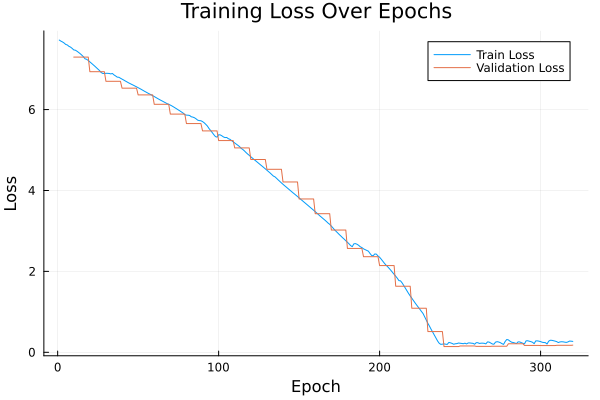

In [17]:
println("=== Trying with MAE loss (might be more robust) ===")

using LorenzParameterEstimation: window_mae

results3 = modular_train!(
    initial_params,                                     # Start from x_s=0.0 again
    sol_shifted;                                        # Target trajectory to fit,                  
    optimizer_config = adamw_config(learning_rate=1e-2, weight_decay=1e-4),
    loss_function = window_mae,                         # Try MAE instead of RMSE
    epochs = 800,                                       
    window_size = 200,                                  
    stride = 100,                                       
    batch_size = 16,                                    
    update_σ = false,                                   
    update_ρ = false,                                   
    update_β = false,                                   
    update_x_s = true,                                  
    update_y_s = false,                                 
    update_z_s = false,                                 
    verbose = true,                                     
    eval_every = 10,                                    
    early_stopping_patience = 80,                      
)

best_params3 = results3.best_params
println("Results with MAE loss:")
println("Estimated x_s: $(best_params3.x_s)")
println("Error: $(abs(best_params3.x_s - 10.0))")


plot(results3.train_loss, label="Train Loss", xlabel="Epoch", ylabel="Loss", title="Training Loss Over Epochs")
plot!(results3.val_loss, label="Validation Loss")


=== Learning all shifts from unstable initial conditions ===
Unstable initial condition: [-0.6457306721039767, -1.4632513788889214, 8.376396254413919]
Target shifts: x_s=5.0, y_s=-3.0, z_s=2.0
   Optimizer: AdamW
   Data: 266 train windows, 66 val windows
   Window size: 300, stride: 150
   Updating: x_s, y_s, z_s

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │   6.981150 │     —      │ x_s=0.100,y_s=0.020,z_s=-0.007
    2 │   6.906324 │     —      │ x_s=0.180,y_s=-0.030,z_s=0.037
    3 │   6.833289 │     —      │ x_s=0.257,y_s=-0.088,z_s=0.064
    4 │   6.764028 │     —      │ x_s=0.329,y_s=-0.156,z_s=0.109
    5 │   6.687085 │     —      │ x_s=0.417,y_s=-0.203,z_s=0.158
    6 │   6.613582 │     —      │ x_s=0.514,y_s=-0.236,z_s=0.197
    7 │   6.541169 │     —      │ x_s=0.596,y_s=-0.293,z_s=0.248
    8 │   6.450361 │     —      │ x_s=0.692,y_s=-0.383,z_s=0.286
    9 │   6.348148 │     —      │ x_s=0.800,y_s=-0.447,z

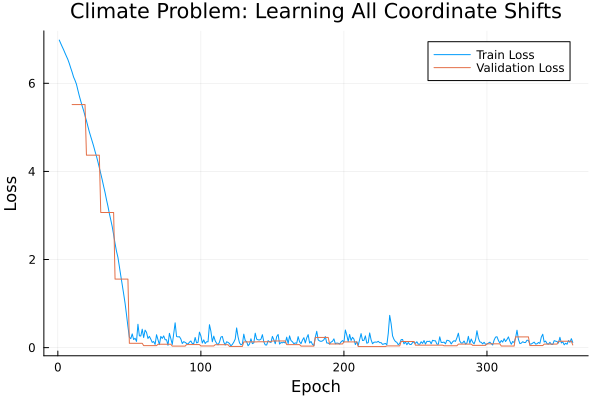

In [18]:
println("=== Learning all shifts from unstable initial conditions ===")

# Generate unstable initial conditions on the attractor
Random.seed!(123)  # Different seed for variation
u0_unstable = randn(3) .+ [0, 0, 10]
println("Unstable initial condition: $u0_unstable")

# Generate target data with ALL shifts: x_s=5.0, y_s=-3.0, z_s=2.0
target_params = with_coordinate_shifts(base_params, 5.0, -3.0, 2.0)
println("Target shifts: x_s=5.0, y_s=-3.0, z_s=2.0")

# Integrate from unstable initial condition
M_climate = 50_000  # Longer integration for climate problem
T_climate = 200.0
dt_climate = T_climate / M_climate

sol_target = integrate(target_params, u0_unstable, (0.0, T_climate), dt_climate)

# Start optimization with no shifts
initial_guess = with_coordinate_shifts(base_params, 0.0, 0.0, 0.0)

results_climate = modular_train!(
    initial_guess,                                      # Start with no shifts
    sol_target;                                         # Target trajectory from unstable IC
    optimizer_config = adamw_config(learning_rate=1e-2, weight_decay=1e-5), # Light regularization
    loss_function = window_rmse,                        # RMSE loss
    epochs = 1500,                                      # More epochs for climate problem
    window_size = 300,                                  # Larger windows for climate statistics
    stride = 150,                                       # 50% overlap
    batch_size = 20,                                    # Medium batch size
    train_fraction = 0.8,                               # More training data
    update_σ = false,                                   # Only learn shifts
    update_ρ = false,                                   
    update_β = false,                                   
    update_x_s = true,                                  # Learn x shift
    update_y_s = true,                                  # Learn y shift  
    update_z_s = true,                                  # Learn z shift
    verbose = true,                                     
    eval_every = 10,                                    # Less frequent evaluation
    early_stopping_patience = 150,                      # More patience for climate problem
    early_stopping_min_delta = 1e-8,                    
)

best_climate = results_climate.best_params
println("\n=== CLIMATE PROBLEM RESULTS ===")
println("True shifts:      x_s=5.0,  y_s=-3.0, z_s=2.0")
println("Estimated shifts: x_s=$(round(best_climate.x_s, digits=3)), y_s=$(round(best_climate.y_s, digits=3)), z_s=$(round(best_climate.z_s, digits=3))")
println("Errors: Δx_s=$(abs(best_climate.x_s - 5.0)), Δy_s=$(abs(best_climate.y_s + 3.0)), Δz_s=$(abs(best_climate.z_s - 2.0))")

# Plot training progress
plot(results_climate.train_loss, label="Train Loss", xlabel="Epoch", ylabel="Loss", 
     title="Climate Problem: Learning All Coordinate Shifts", logy=true)
plot!(results_climate.val_loss, label="Validation Loss")

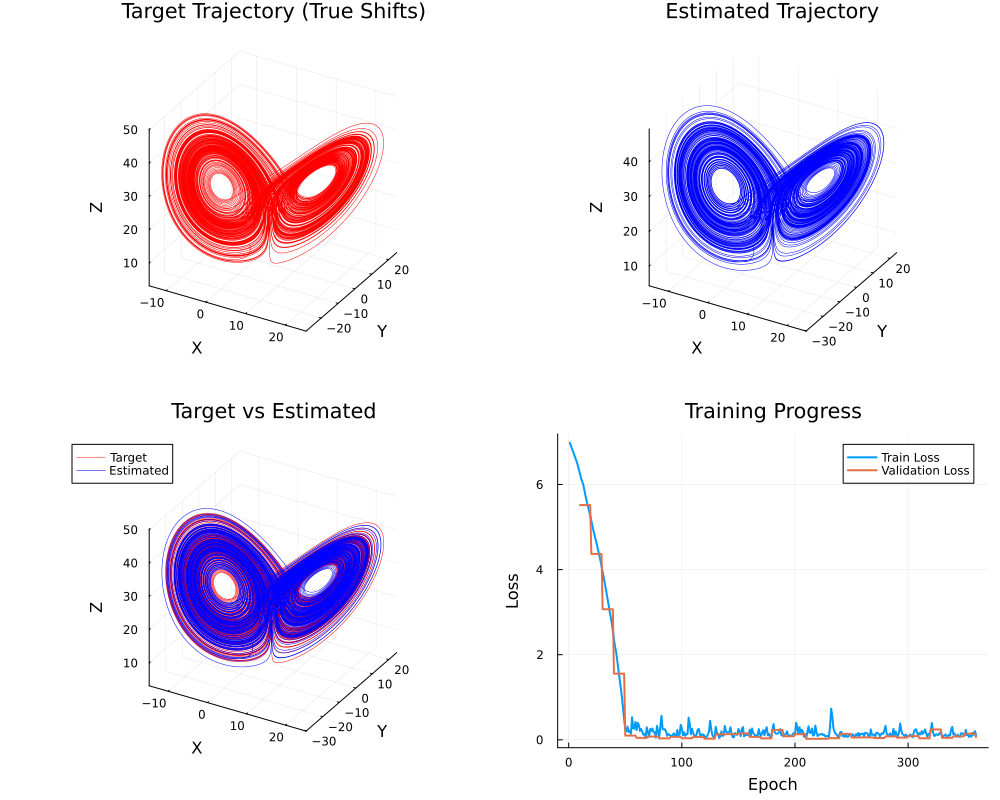

In [19]:
# Plot comparison of trajectories and parameter estimation results
p1 = plot(sol_target.u[:, 1], sol_target.u[:, 2], sol_target.u[:, 3];
          title="Target Trajectory (True Shifts)", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:red, linewidth=0.5, seriestype=:path3d, legend=false)

# Generate trajectory with estimated parameters
sol_estimated = integrate(best_climate, u0_unstable, (0.0, T_climate), dt_climate)

p2 = plot(sol_estimated.u[:, 1], sol_estimated.u[:, 2], sol_estimated.u[:, 3];
          title="Estimated Trajectory", xlabel="X", ylabel="Y", zlabel="Z", 
          linecolor=:blue, linewidth=0.5, seriestype=:path3d, legend=false)

# Overlay both trajectories
p3 = plot(sol_target.u[:, 1], sol_target.u[:, 2], sol_target.u[:, 3];
          title="Target vs Estimated", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:red, linewidth=0.5, seriestype=:path3d, label="Target")
plot!(p3, sol_estimated.u[:, 1], sol_estimated.u[:, 2], sol_estimated.u[:, 3];
      linecolor=:blue, linewidth=0.5, seriestype=:path3d, label="Estimated")

# Parameter convergence plot
epochs = 1:length(results_climate.train_loss)
p4 = plot(epochs, results_climate.train_loss, label="Train Loss", 
          xlabel="Epoch", ylabel="Loss", title="Training Progress", 
          logy=true, linewidth=2)
plot!(p4, epochs, results_climate.val_loss, label="Validation Loss", linewidth=2)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000, 800))